# Benchmarking antimicrobial peptides


In this notebook, we use seqme to evaluate antimicrobial peptide sequences.


In [ ]:
%load_ext autoreload
%autoreload 2

import pickle

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

import seqme as sm

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Data


Let's load the datasets.


In [ ]:
DATASET_PATHS = {
    # Databases
    "UniProt": "./data/uniprot/uniprot_8_50_100.fasta",
    "AMP-data": "./data/amps.fasta",
    "AMPs": "./data/amps_hq.fasta",
    "DBAASP": "./data/dbaasp.fasta",
    # Models
    "AMP-Diffusion": "./data/amp-diffusion.fasta",
    "AMP-GAN": "./data/amp-gan.fasta",
    "CPL-Diff": "./data/cpl-diff.fasta",
    "HydrAMP": "./data/hydramp.fasta",
    "OmegAMP": "./data/omegamp/unconditional.fasta",
    "OmegAMP (prop.)": "./data/omegamp/property-conditional.fasta",
    "OmegAMP (subset)": "./data/omegamp/subset-hq-conditional.fasta",
}

In [ ]:
datasets = {name: sm.read_fasta(path) for name, path in DATASET_PATHS.items()}

In [ ]:
for model_name, sequences in datasets.items():
    print(f"{model_name}: {len(sequences)} sequences")

UniProt: 2933310 sequences
AMP-data: 38473 sequences
AMPs: 7204 sequences
DBAASP: 8967 sequences
AMP-Diffusion: 47671 sequences
AMP-GAN: 150000 sequences
CPL-Diff: 49985 sequences
HydrAMP: 50000 sequences
OmegAMP: 149504 sequences
OmegAMP (prop.): 50000 sequences
OmegAMP (subset): 49152 sequences


Let's setup the data and models.


In [ ]:
sources = [
    "AMP-Diffusion",
    "AMP-GAN",
    "CPL-Diff",
    "HydrAMP",
    "OmegAMP",
    "OmegAMP (prop.)",
    "OmegAMP (subset)",
    "UniProt",
    "AMP-data",
]

n_samples = 40_000  # 3_000
seed = 42

benchmark_datasets = {
    source: sm.random_subset(datasets[source], n_samples=n_samples, seed=seed)
    if len(datasets[source]) > n_samples
    else datasets[source]
    for source in sources
}
# benchmark_datasets["DBAASP (shuffled)"] = sm.shuffle_characters(datasets["DBAASP"], seed=seed)
benchmark_datasets["AMP-data (permuted)"] = sm.shuffle_characters(benchmark_datasets["AMP-data"], seed=42)

seqs_amps = datasets["AMPs"]
seqs_train = datasets["AMP-data"]

## Models


Let's load the models and set up the cache.


In [ ]:
CACHE_PATH = "cache.pkl"  # "cache_pep600.pkl"

if CACHE_PATH:
    with open(CACHE_PATH, "rb") as f:
        init_cache = pickle.load(f)
else:
    init_cache = None

Let's setup the third-party models.


Let's setup AMPlify.


In [ ]:
# !conda create -n amplify_env python=3.9 -y

In [ ]:
amplify = sm.models.ThirdPartyModel(
    entry_point="predict:predict",
    repo_path="../plugins/thirdparty/amplify",
    # python_bin="/opt/anaconda3/envs/amplify_env/bin/python",
    python_bin="/home/icb/rasmus.larsen/tools/apps/miniconda3/envs/amplify_env/bin/python",
    repo_url="https://github.com/szczurek-lab/seqme-thirdparty",
    branch="amplify",
)

Let's setup amPEPpy.


In [ ]:
# !conda create -n ampeppy_env python=3.8 -y

In [ ]:
ampeppy = sm.models.ThirdPartyModel(
    entry_point="amPEPpy.predict:predict",
    repo_path="../plugins/thirdparty/ampep",
    # python_bin="/opt/anaconda3/envs/ampep_env/bin/python",
    python_bin="/home/icb/rasmus.larsen/tools/apps/miniconda3/envs/ampep_env/bin/python",
    repo_url="https://github.com/szczurek-lab/seqme-thirdparty",
    branch="ampeppy",
)

Let's setup the cache.


In [ ]:
def my_embedder(sequences: list[str]) -> np.ndarray:
    lengths = [len(sequence) for sequence in sequences]
    counts = [sequence.count("K") for sequence in sequences]
    return np.array([lengths, counts]).T


esm2 = sm.models.Esm2(
    model_name=sm.models.Esm2Checkpoint.shukla_group_peptide_650M,
    batch_size=512,
    device=device,
    verbose=False,
)

cache = sm.Cache(
    models={
        "embedder": my_embedder,
        "esm2-embed": esm2.embed,
        "esm2-perplexity": lambda seqs: esm2.compute_pseudo_perplexity(seqs, mask_size=3),
        "gravy": sm.models.Gravy(),
        "charge": sm.models.Charge(),
        "amphiphilicity": sm.models.HydrophobicMoment(),
        "amPEPpy": ampeppy,
        "AMPlify": amplify,
    },
    init_cache=init_cache,
)

Let's look at the embeddings of the embedding model.


In [ ]:
datasets_to_plot_names = ["UniProt", "AMP-data"]
# @TODO: include shuffled AMP-data?

colors = ["#d66868", "#68d6bc"]

n_samples = 30_000
seed = 42

datasets_to_plot = {
    name: sm.random_subset(datasets[name], n_samples=n_samples, seed=seed)
    if len(sequences) > n_samples
    else datasets[name]
    for name in datasets_to_plot_names
}

In [ ]:
embedder_name = "esm2-embed"
embedder = cache.model(embedder_name)

embeddings = {name: embedder(dataset) for name, dataset in datasets_to_plot.items()}

## Metrics


In [ ]:
uniprot = sm.random_subset(datasets["UniProt"], n_samples=30_000, seed=42)

In [ ]:
charge_fn = cache.model("charge")
amphiphilicity_fn = cache.model("amphiphilicity")

uniprot_charge = charge_fn(uniprot)
uniprot_amphiphilicity = amphiphilicity_fn(uniprot)

amp_data_charge = charge_fn(seqs_amps)
amp_data_amphiphilicity = amphiphilicity_fn(seqs_amps)

In [ ]:
xs_tsne = sm.utils.tsne(list(embeddings.values()))

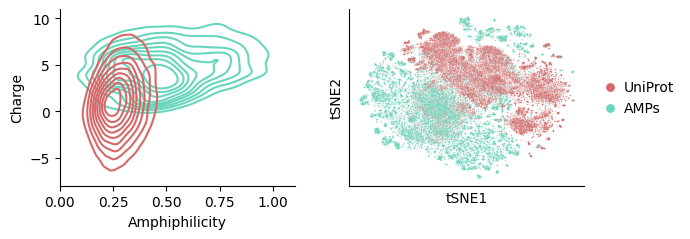

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(7, 2.5))  # , dpi=200)

ax = axes[0]

sns.kdeplot(
    x=amp_data_amphiphilicity,
    y=amp_data_charge,
    fill=False,
    thresh=0.15,
    color="#68d6bc",
    ax=ax,
    bw_method="silverman",
)

sns.kdeplot(
    x=uniprot_amphiphilicity,
    y=uniprot_charge,
    fill=False,
    thresh=0.15,
    color="#d66868",
    ax=ax,
    bw_method="silverman",
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlim([0, 1.1])
ax.set_ylim([-8, 11])
ax.set_xlabel("Amphiphilicity")
ax.set_ylabel("Charge")

ax = axes[1]

sm.utils.plot_embeddings(
    xs_tsne,
    colors=colors,
    alpha=0.15,
    point_size=1,
    legend_point_size=40,
    ax=ax,
    xlabel="tSNE1",
    ylabel="tSNE2",
    labels=["UniProt", "AMPs"],
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

leg = ax.legend(
    loc="center left",
    bbox_to_anchor=(1.0, 0.5),
    frameon=False,
    handletextpad=0,
    # fontsize=9,
)

for lh in leg.legend_handles:
    lh.set_sizes([40])
    lh.set_alpha(1.0)

fig.tight_layout(w_pad=2.5)

Using "Silverman" to estimate the kde bandwidth appears to work well here. Also notice AMPs usually have a positive charge.


Let's select the metrics.


In [ ]:
embedder = "esm2-embed"  # "embedder"


metrics = [
    sm.metrics.Uniqueness(),
    sm.metrics.Novelty(reference=seqs_train),
    sm.metrics.FBD(reference=seqs_amps, embedder=cache.model(embedder)),
    sm.metrics.MMD(reference=seqs_amps, embedder=cache.model(embedder), device=device),
    sm.metrics.Fold(
        sm.metrics.Precision(
            neighborhood_size=3, reference=seqs_train, embedder=cache.model(embedder), strict=True, device=device
        ),
        split_size=len(seqs_train),
        drop_last=True,
    ),
    sm.metrics.Fold(
        sm.metrics.Recall(
            neighborhood_size=3, reference=seqs_train, embedder=cache.model(embedder), strict=True, device=device
        ),
        split_size=len(seqs_train),
        drop_last=True,
    ),
    # ID(predictor=cache.model("esm2-perplexity"), name="Perplexity", objective="minimize"),
    # @TODO: ID y_mic
    sm.metrics.ID(predictor=cache.model("AMPlify"), name="AMPlify", objective="maximize"),
    sm.metrics.ID(predictor=cache.model("amPEPpy"), name="amPEPpy", objective="maximize"),
    sm.metrics.AuthPct(train_set=seqs_train, embedder=cache.model(embedder)),
    sm.metrics.ConformityScore(
        reference=seqs_amps,
        predictors=[cache.model("amphiphilicity"), cache.model("charge")],
        kde_bandwidth="silverman",
    ),
]

`Fold` computes the metrics multiple using different folds, and aggregate the values (mean and standard deviation).

Wrapping `Fold` around the `Precision` and `Recall` metric, removes the sample size bias inherent in these metrics (introduced by k-NN), while still utilizing as many of the available sequences as possible.


## Table


Let's compute the metrics for each group of sequences.


In [ ]:
df = sm.evaluate(benchmark_datasets, metrics)

100%|██████████| 100/100 [1:03:28<00:00, 38.08s/it, data=AMP-data (permuted), metric=Conformity score]


Let's look at the results.


In [ ]:
sm.show(df, n_decimals=[3, 3, 2, 2, 2, 2, 2, 2, 2, 3])

,Uniqueness↑,Novelty↑,FBD↓,MMD↓,Precision↑,Recall↑,AMPlify↑,amPEPpy↑,Authenticity↑,Conformity score↑
AMP-Diffusion,0.911,0.997,2.59,9.20,0.57,0.39,0.15±0.30,0.35±0.23,0.86,0.341±0.002
AMP-GAN,0.996,1.000,6.53,30.15,0.77,0.26,0.48±0.44,0.48±0.22,0.78,0.444±0.002
CPL-Diff,0.976,0.985,1.24,3.22,0.56,0.66,0.88±0.26,0.70±0.16,0.86,0.415±0.002
HydrAMP,1.000,1.000,5.87,22.75,0.49,0.51,0.58±0.38,0.52±0.15,0.90,0.324±0.002
OmegAMP,0.946,0.912,2.19,10.94,0.72,0.77,0.64±0.39,0.59±0.20,0.73,0.392±0.002
OmegAMP (prop.),0.982,0.972,1.68,4.27,0.63,0.64,0.83±0.31,0.71±0.16,0.83,0.518±0.002
OmegAMP (subset),0.949,0.929,1.01,4.50,0.71,0.72,0.86±0.26,0.69±0.17,0.77,0.509±0.002
UniProt,1.000,1.000,5.82,20.48,0.67,0.63,0.37±0.32,0.60±0.14,0.83,0.242±0.002
AMP-data,1.000,0.000,1.26,5.64,1.00,1.00,0.67±0.39,0.62±0.21,0.00,0.381±0.002
AMP-data (permuted),1.000,0.999,4.87,22.49,0.77,0.72,0.57±0.37,0.58±0.17,0.69,0.369±0.002


Optional: Saving the cache to a file.


In [ ]:
OUT_CACHE_PATH = "new_cache.pkl"

with open(OUT_CACHE_PATH, "wb") as f:
    pickle.dump(cache.get(), f)